In [26]:
from datetime import datetime, timedelta

# pandas and plotting libraries for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# module containing functions for manipulation pyspark dataframes
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

# class which will let us create spark objects
from pyspark.sql import SparkSession

# modeling
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# helper functions for the class
from helpers import display, read_df, write_df, feature_importances

## [PySpark ML docs](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html)

## Create a Spark Session

In [27]:
spark = (
    SparkSession
    .builder
    .appName('model')
    .master('local[2]')
    .getOrCreate()
)

## Feature generation function

In [28]:
def build_features(raw_df):
    avg_miles_by_census_tract = (
        raw_df
        .groupby('dropoff_census_tract')
        .agg(f.avg(f.col('trip_miles')).alias('avg_trip_miles_by_dropoff_census_tract'))
    )

    features = (
        raw_df
        .where(f.col('tips').isNotNull())
        .join(avg_miles_by_census_tract, on='dropoff_census_tract')
        .select(
            'trip_id',
            'company',
            'trip_miles',
            'fare',
            f.month('start_time').alias('start_month'),
            f.dayofweek('start_time').alias('start_day_of_week'),
            f.hour('start_time').alias('start_hour'),
            (f.unix_timestamp(f.col('end_time')) - f.unix_timestamp(f.col('start_time'))).alias('trip_minutes'),
            'avg_trip_miles_by_dropoff_census_tract',
            f.col('tips').alias('label'),
        )
    )
    
    return features

## Build Pipeline

In [29]:
df = read_df(spark, '../taxi_2016')

In [30]:
# only have tip data for credit card transactions
tips = df.where(f.col('payment_type') == 'Credit Card')

In [31]:
tips.count()

1317855

In [32]:
tips = tips.sample(fraction=.1)

In [33]:
train_raw, test_raw = tips.randomSplit([0.7, 0.3])

In [34]:
train = build_features(train_raw)

In [35]:
test = build_features(test_raw)

In [36]:
# check for nulls
display(train.agg(*[f.sum(f.col(c).isNull().cast(t.IntegerType())).alias(c) for c in train.columns]))

,trip_id,company,trip_miles,fare,start_month,start_day_of_week,start_hour,trip_minutes,avg_trip_miles_by_dropoff_census_tract,label
0,0,24248,0,0,0,0,0,0,0,0


In [37]:
categorical_cols = ['start_month', 'start_day_of_week', 'start_hour', 'company']
indexed_categorical_cols = [c + '_ind' for c in categorical_cols]

numeric_cols = ['trip_miles', 'fare', 'trip_minutes', 'avg_trip_miles_by_dropoff_census_tract']
imputed_numeric_cols = [c + '_imp' for c in numeric_cols]

In [38]:
train = train.select('trip_id', *categorical_cols, *[f.col(c).cast(t.DoubleType()) for c in numeric_cols], 'label')
train = train.fillna('no_company')

In [39]:
test = test.select('trip_id', *categorical_cols, *[f.col(c).cast(t.DoubleType()) for c in numeric_cols], 'label')
test = test.fillna('no_company')

In [40]:
pipeline = Pipeline().setStages(
    [
        *[StringIndexer(inputCol=c, outputCol=c+'_ind', handleInvalid='keep') for c in categorical_cols],
        Imputer(inputCols=numeric_cols, outputCols=imputed_numeric_cols),
        VectorAssembler(inputCols=imputed_numeric_cols + indexed_categorical_cols, outputCol='features'),
        RandomForestRegressor(maxBins=60),
    ]
)

In [41]:
train.count()

67650

In [42]:
model = pipeline.fit(train)

In [43]:
predictions = model.transform(test)

## Evaluate

In [44]:
evaluator = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)

In [45]:
print('RMSE on test data = {}'.format(rmse))

RMSE on test data = 1.6288485687758003


In [46]:
print('Most important features:')
feature_importances(predictions, model.stages[6], 20)

Most important features:
start_day_of_week_ind: 0.459
start_hour_ind: 0.310
start_month_ind: 0.176
company_ind: 0.041
avg_trip_miles_by_dropoff_census_tract_imp: 0.008
trip_minutes_imp: 0.005
fare_imp: 0.001
trip_miles_imp: 0.001


In [47]:
to_plot = (
    predictions
    .select('prediction', 'label')
    .sample(withReplacement=False, fraction=.01)
    .toPandas()
)

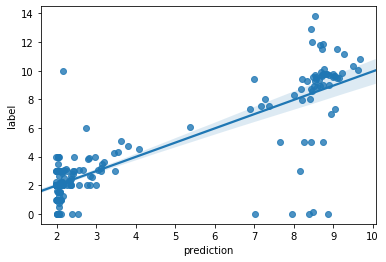

In [48]:
plt.figure()
sns.regplot(to_plot['prediction'], to_plot['label'])

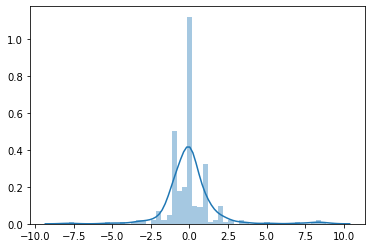

In [49]:
plt.figure()
sns.distplot(to_plot['prediction'] - to_plot['label'])

In [50]:
spark.stop()